# Clasa pentru modelul MobileNetV2

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetSteering(nn.Module):
    def __init__(self, num_classes=1):
        super(MobileNetSteering, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        in_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        x = self.mobilenet(x)
        return x

/home/bogdan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functiile pentru augmentarea setului de date

In [2]:
import random
import numpy as np
from imgaug import augmenters as img_aug

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3)) 
    image = zoom.augment_image(image)
    return image

def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

def pan(image):
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 5)  
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

def img_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) 
    image = cv2.resize(image, (150, 66)) 
    return image

# Incarcarea, augmentarea si pregatirea seturilor de date pentru antrenare, validare si testare

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import torchvision

# dataset
data_folder = "Set_date_complet_28_iunie/imagini/"
adnoatations_csv = "Set_date_complet_28_iunie/adnotari_angle.csv"
data = []

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

width = 200
height = 66

with open(adnoatations_csv, 'r') as csvfile:
    for line in csvfile:
        name, x, y, angle, comp_angle = line.split(",")
        comp_angle = 180 - float(angle)
        comp_angle = int(round(comp_angle))
        
        image = data_folder + name 
        if os.path.isfile(image) and os.stat(image).st_size > 0:
            image = cv2.imread(image, cv2.IMREAD_COLOR)
            
            image_add = img_preprocess(image)
            image_add = transform(image_add)
            data.append([image_add, comp_angle]) 

            for i in range(5): # pentru fiecare poza din setuld de date mai vin cu inca 5 augmentate
                image_add, steering_angle = random_augment(image, comp_angle)
                image_add = img_preprocess(image_add)
                image_add = transform(image_add)
                data.append([image_add, steering_angle])
                
    csvfile.close()
    
    print("Generated dataset of " + str(len(data)) + " items")

Generated dataset of 4416 items


In [4]:
data[1][0].shape

torch.Size([3, 66, 150])

In [5]:
from sklearn.model_selection import train_test_split

# impart setul de date in 80% pentru antrenare si 20% pentru validare
data_train, data_validation = train_test_split(data, test_size=0.2, random_state=42)
# din cei 20% pentru validare, folosesc 20% pentru testare
data_validation, data_test = train_test_split(data_validation, test_size=0.2, random_state=42)

In [6]:
print("Training dataset has " + str(len(data_train)) + " images")
print("Validation dataset has " + str(len(data_validation)) + " images")
print("Testing dataset has " + str(len(data_test)) + " images")

Training dataset has 3532 images
Validation dataset has 707 images
Testing dataset has 177 images


In [7]:
BATCH_SIZE = 256 # dimensiunea batchului adjustata in functie de incarcarea VRAM

In [8]:
training_loader = torch.utils.data.DataLoader(data_train,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_loader = torch.utils.data.DataLoader(data_validation,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

testing_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=1,
                                              shuffle=True)

# Antrenarea modelului

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda")
model = MobileNetSteering().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)

train_losses = [] 
val_losses = []  

model_name = 'mobilenetv2_8_iunie_200_66.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, steering_angles in training_loader:
        # images = images.to(torch.float16)
        images = images.to(device)
        
        steering_angles = steering_angles.to(device)
        # steering_angles = steering_angles.to(torch.qint8)
        steering_angles = steering_angles.to(torch.uint8)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, steering_angles.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)  

    train_loss = train_loss / len(training_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images_val, steering_angles_val in validation_loader:
            # images_val = images_val.to(torch.float16)
            images_val = images_val.to(device)
            
            steering_angles_val = steering_angles_val.to(device)
            # steering_angles = steering_angles.to(torch.qint8)
            steering_angles_val = steering_angles_val.to(torch.uint8)
            
            outputs_val = model(images_val)
            loss_val = criterion(outputs_val, steering_angles_val.float().unsqueeze(1))
            val_loss += loss_val.item() * images_val.size(0) 
    
    val_loss = val_loss / len(validation_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)
    
    if epoch == 0:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_name)
        print("First epoch, saving model")
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), model_name)
        print("Validation loss improves, saving model.")
        best_val_loss = val_loss

/home/bogdan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bogdan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/bogdan/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50], Train Loss: 7423.0978, Val Loss: 5732.0393
First epoch, saving model
Epoch [2/50], Train Loss: 5364.8127, Val Loss: 4494.6478
Validation loss improves, saving model.
Epoch [3/50], Train Loss: 3824.2951, Val Loss: 3420.2246
Validation loss improves, saving model.
Epoch [4/50], Train Loss: 2473.1155, Val Loss: 2684.0439
Validation loss improves, saving model.
Epoch [5/50], Train Loss: 1448.2373, Val Loss: 693.8692
Validation loss improves, saving model.
Epoch [6/50], Train Loss: 789.0369, Val Loss: 438.2242
Validation loss improves, saving model.
Epoch [7/50], Train Loss: 396.4930, Val Loss: 557.4596
Epoch [8/50], Train Loss: 208.7798, Val Loss: 240.9703
Validation loss improves, saving model.
Epoch [9/50], Train Loss: 104.5930, Val Loss: 92.8619
Validation loss improves, saving model.
Epoch [10/50], Train Loss: 69.7082, Val Loss: 87.3707
Validation loss improves, saving model.
Epoch [11/50], Train Loss: 42.5669, Val Loss: 53.6316
Validation loss improves, saving model.
Epo

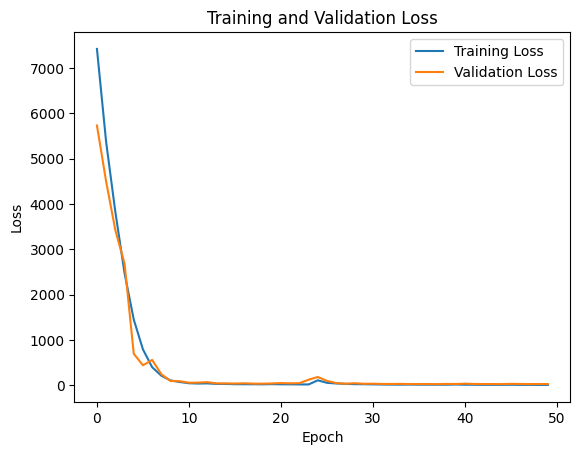

<Figure size 640x480 with 0 Axes>

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.savefig('Training and Validation loss MobilenetV2.png')

# Verificarea modelului pe setul de testare

In [11]:
model.eval()  # Set the model to evaluation mode
running_loss = 0.0
criterion = nn.MSELoss()

with torch.no_grad():  # Disable gradient computation
    for images, labels in testing_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(-1, 1).float()  # Reshape labels and convert to FloatTensor
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

total_loss = running_loss / len(testing_loader.dataset)

print("Loss on test set: " + str(total_loss))

Loss on test set: 22.025306990249135


In [12]:
print("Number of parameters: " + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of parameters: 2225153
